# RNN Models for Determining LKML Authors

We posit that it would be interesting to be able to learn people's style of writing, such that they could be identified by their writing style. This type of prediction task has a variety of applications in advertisement targeting and other domains in which it is useful to identify people based on their online interactions, especially in cases of anonymous online communications.

Our task is to examine the Linux Kernel Mailing List, a platform for Linux Kernel developers to communicate about bugs, fixes, and other matters pertinent to the upkeep of the Linux Kernel, and attempt to learn how to determine the author of a particular message in the mailing list. For this particular prediction task, it could be useful for determining contributions to the Linux Kernel itself or determining what a particular person tends to discuss or what their style of message is. However, here, we will concern ourselves primarily with the issue of reliably determining authorship based on the contents of a particular message.

The dataset we use can be found at https://www.kaggle.com/msoedov/linux-kernel-mailing-list-archive. It consists of 130,000 messages from the LKML, along with the author, time, topic, and the message size.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint
from IPython.display import SVG

from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, GRU
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from sklearn.metrics import f1_score, confusion_matrix

Using TensorFlow backend.


In [2]:
file_dir = os.path.join(os.pardir, 'data', 'archive.csv')

lkml_df = pd.read_csv(file_dir)

In [3]:
lkml_df.head()

,Unnamed: 0,Author,Time,Topic,Msg,Size
0,1,Jarkko Sakkinen,"Thu, 26 Oct 2017 21:07:28 +0200",Re: Fixing CVE-2017-15361,"On Thu, Oct 26, 2017 at 03:51:27PM +0000, Alex...",2541
1,2,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:40 -0700",[PATCH v7 01/13] xen/pvcalls: introduce the pv...,Introduce a xenbus frontend for the pvcalls pr...,148
2,3,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:38 -0700 (PDT)",[PATCH v7 00/13] introduce the Xen PV Calls fr...,"Hi all,\nthis series introduces the frontend f...",1944
3,4,Stefano Stabellini,"Thu, 26 Oct 2017 12:11:42 -0700",[PATCH v7 03/13] xen/pvcalls: connect to the b...,Implement the probe function for the pvcalls f...,325
4,5,James Morris,"Thu, 26 Oct 2017 21:06:29 +0200 (CEST)",Re: regression in 4.14-rc2 caused by apparmor:...,"On Thu, 26 Oct 2017, Linus Torvalds wrote:\n> ...",1036


In [4]:
lkml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127627 entries, 0 to 127626
Data columns (total 6 columns):
Unnamed: 0    127627 non-null int64
Author        127627 non-null object
Time          127627 non-null object
Topic         127627 non-null object
Msg           127627 non-null object
Size          127627 non-null int64
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


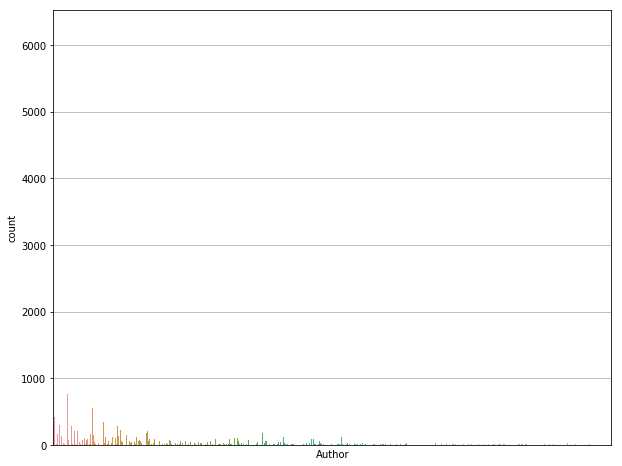

In [5]:
sns.countplot(data=lkml_df, x='Author')
plt.xticks([])
plt.show()

We'll go ahead and select for only authors who have a significant contribution to the mailing list. Not only does this make performance easier to evaluate, but it will also make it much easier to learn each author, supposing such a thing is even possible. Trying to learn style from only two or three examples is ill-advised.

In [6]:
high_contrib = np.unique(lkml_df.Author)[np.unique(lkml_df.Author, return_counts=True)[1] >= 150]
contrib_lkml = lkml_df.loc[lkml_df.Author.isin(high_contrib)]
contrib_lkml.shape

(78158, 6)

Good, now we only have authors who have contributed at least 150 entries to the LKML, and we still have more nearly two-thirds of the dataset left over.

In [7]:
import re

rand_idx = np.random.choice(contrib_lkml.index)
print(contrib_lkml.Msg[rand_idx])
print('==========================================================')
print(contrib_lkml.Author[rand_idx])
print('==========================================================')

On 6 March 2017 at 09:28, Piotr Sroka <piotrs@cadence.com> wrote:
> Add support for HS400ES mode to Cadence SDHCI driver.
>
Ulf Hansson


If we look through here enough, we'll find that a lot of times, the author of a specific message will be kind enough to sign it, giving away completely the answer. As this this is not what we set out to do and is severely uninteresting, we will try to remove any mentions of the author's name in their message.

In [8]:
import re

def remove_name(row):
    result = row['Msg']
    for word in row['Author'].split():
        if len(word) > 2:
            check_word = re.sub(r'[\",\(\)\.\\]', '', word)
            result = re.sub(check_word, '', result)
    return result
    
contrib_lkml['Text'] = contrib_lkml.apply(lambda row : remove_name(row), axis=1)

/hpc/applications/anaconda/3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
import re

# rand_idx = np.random.choice(contrib_lkml.index)
print(contrib_lkml.Text[rand_idx])
print('==========================================================')
print(contrib_lkml.Author[rand_idx])
print('==========================================================')

On 6 March 2017 at 09:28, Piotr Sroka <piotrs@cadence.com> wrote:
> Add support for HS400ES mode to Cadence SDHCI driver.
>
Ulf Hansson


That's much better. If we wanted to go another step further, we could remove the full last few lines, essentially anytime we detected a signature, so as to void personal flourishes giving someone away, but it may actually be interesting to learn those.

We will now import GloVe, in order to embed the words we are interested in to make them useable as inputs to our RNN.

## Glorified Screwing Around (Data Exploration)

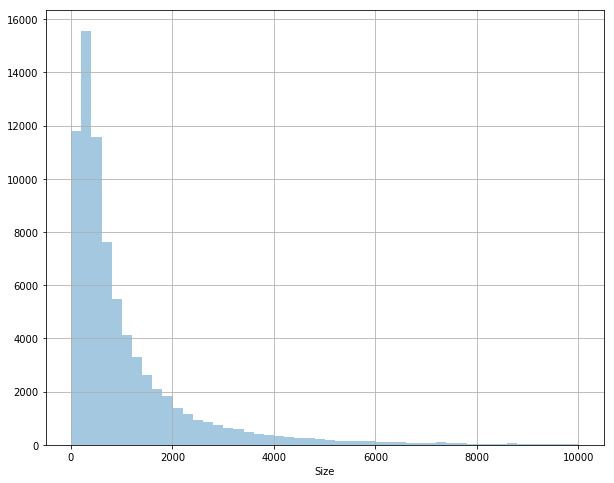

In [10]:
sns.distplot(contrib_lkml[contrib_lkml.Size < 10000].Size, norm_hist=False, kde=False)
plt.show()

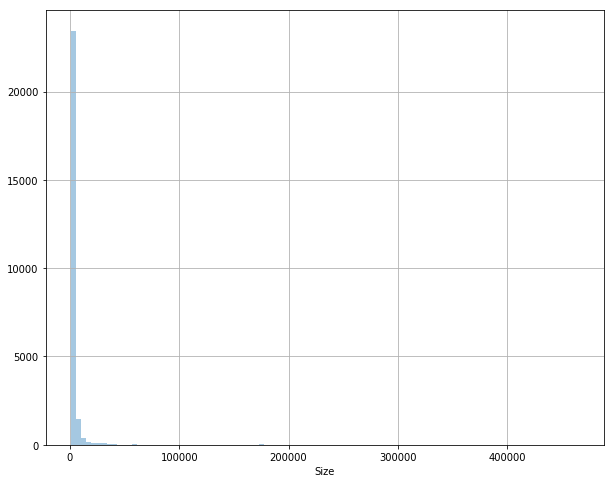

In [11]:
sns.distplot(contrib_lkml[contrib_lkml.Size > 1000].Size, norm_hist=False, kde=False, bins=100)
plt.show()

1000 words looks like it gets the full sequence in the majority of our data anyways, so we can use that as our max length.

In [12]:
max_length = 1000

In [13]:
n_classes = np.unique(contrib_lkml.Author).shape[0]
n_classes

191

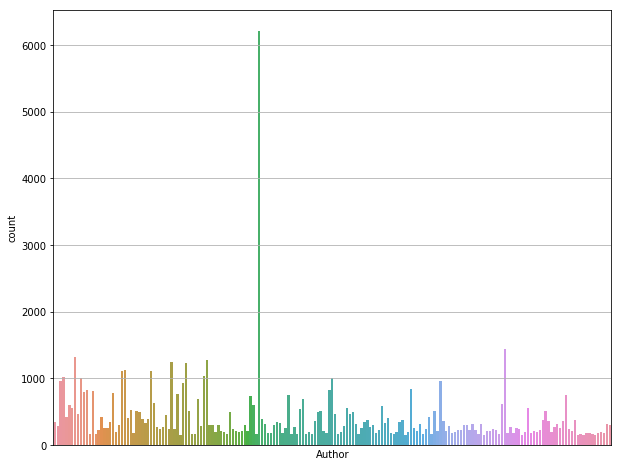

In [14]:
sns.countplot(contrib_lkml.Author)
plt.xticks([])
plt.show()

Oh, my...

In [15]:
contrib_lkml.Author.value_counts().argmax()

'Greg Kroah-Hartman'

[For the interested](https://en.wikipedia.org/wiki/Greg_Kroah-Hartman)

But also because we're the curious type, let's see about everyone's favorite Linus Torvalds.

In [16]:
np.array([contrib_lkml.Author == 'Linus Torvalds']).sum()

489

Not bad for the man the kernel was named for.

### Done Screwing Around, Back to the $\text{Real Data Science}^{\text{TM}}$

In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None

# tokenizer logic adapted from 
# https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb
# taken in its entirety

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(contrib_lkml.Text.values)
sequences = tokenizer.texts_to_sequences(contrib_lkml.Text.values)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 238800 unique tokens. Distilled to 238800 top words.


In [18]:
# we have a lot of unique words, so a larger embedding is necessary
glove_file = os.path.join(os.pardir, 'data', 'glove.6B.200d.txt') 

# code for setting up GloVe embedding copied from:
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
# altered parts regarding the structure of the embedding layer and the size

embeddings_index = {}
f = open(glove_file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_size = 200

embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embed_layer = Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

authors = LabelBinarizer().fit_transform(contrib_lkml.Author)

X_train, X_test, y_train, y_test = train_test_split(sequences, authors)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## Evaluation Criteria

### Metrics

As we saw above, we don't have too much of a problem with unbalanced classes. Sure, some people contribute much more than others, but everyone aside from the top contributor is within an order of magnitude of everyone else in numbers of training instances. Since this is the case, we need not worry too much about macro- vs micro-averaging schemes.

For this task, we ought to be concerned primarily with how well we are doing at picking up examples of a particular class. Especially if this algorithm, or something similar, were to be rolled out to a production-scale detection algorithm for determining identities online, we would be much more concerned with being able tograb as many of the instances of someone's writings online, which can then be further analyzed to determine specific identities. For this reason, we will use a macro-averaged recall score when evaluating models.

In [20]:
from sklearn.metrics import recall_score

scorer = lambda y_true, y_pred : recall_score(y_true, y_pred, average='macro')

### Cross-Validation

As before, we don't have to worry too much about unbalanced classes, and the number of instances is very large relative to the number of classes, so we will not stratify our cross-validation strategy. We could, but in this case it likely will not be worth it.

The strategy we will use is shuffle-splitting. This is mostly a performance concern, as fitting a large number of folds for the large amounts of data that we have would take a very long time, but shuffle-splits should go faster. We will also only do 3 splits to save time. If more become necessary to distinguish between the performance of a small number of models, we will run with more splits.

Also, to save time, we will have the size of each split represent half the size of the data.

In [21]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=3, test_size=0.17, train_size=0.33)

## Finding Models that Work

In [22]:
# this code can be found in my previous projects at https://github.com/carterkoehler

def predict_categ(model, data):
    return(np.argmax(model.predict(data), axis=1))

def evaluate_confusion(model, test_data, test_target, normalize=True, print_recall=True):
    target_int = np.argmax(test_target, axis=1)
    yhat = predict_categ(model, test_data)
    conf = confusion_matrix(target_int, yhat[:,np.newaxis])

    if normalize:
        conf = conf / np.unique(target_int, return_counts=True)[1][:, np.newaxis]
    if print_recall:
        print('Recall score of this model is {}'.format(scorer(yhat, target_int)))
        
    sns.heatmap(conf, annot=False)
    plt.show()
    
def plot_history(history):
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('Cross-Entropy Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    plt.show()

In [54]:
rnn_generic = Sequential()

rnn_generic.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
rnn_generic.add(LSTM(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_generic.add(Dense(200, activation='relu'))
rnn_generic.add(Dropout(0.2))
rnn_generic.add(Dense(n_classes, activation='softmax'))

rnn_generic.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_generic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_13 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 191)               38391     
Total params: 48,159,591
Trainable params: 399,391
Non-trainable params: 47,760,200
_________________________________________________________________


In [95]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=3)

Train on 58618 samples, validate on 19540 samples
Epoch 1/3
58618/58618 [==============================] - 155s 3ms/step - loss: 4.6570 - acc: 0.1225 - val_loss: 4.2804 - val_acc: 0.1723
Epoch 2/3
58618/58618 [==============================] - 155s 3ms/step - loss: 4.1422 - acc: 0.1979 - val_loss: 3.7785 - val_acc: 0.2478
Epoch 3/3
58618/58618 [==============================] - 155s 3ms/step - loss: 3.7776 - acc: 0.2483 - val_loss: 3.5547 - val_acc: 0.2805


We're doing alright, but it looks like we can keep training. Let's go overboard.

In [96]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 155s 3ms/step - loss: 3.5186 - acc: 0.2795 - val_loss: 3.2819 - val_acc: 0.3118
Epoch 2/10
58618/58618 [==============================] - 155s 3ms/step - loss: 3.3021 - acc: 0.3076 - val_loss: 3.0767 - val_acc: 0.3458
Epoch 3/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.0991 - acc: 0.3406 - val_loss: 2.8294 - val_acc: 0.3903
Epoch 4/10
58618/58618 [==============================] - 155s 3ms/step - loss: 2.8869 - acc: 0.3814 - val_loss: 2.6766 - val_acc: 0.4118
Epoch 5/10
58618/58618 [==============================] - 155s 3ms/step - loss: 2.6843 - acc: 0.4179 - val_loss: 2.4792 - val_acc: 0.4508
Epoch 6/10
58618/58618 [==============================] - 156s 3ms/step - loss: 2.4612 - acc: 0.4550 - val_loss: 2.1868 - val_acc: 0.5094
Epoch 7/10
58618/58618 [==============================] - 156s 3ms/step - loss: 2.2437 - acc: 0.4937 - val_loss: 1.9370 - 

Holy shit, we're still improving! Let's keep going.

In [97]:
history_generic = rnn_generic.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 155s 3ms/step - loss: 1.5851 - acc: 0.6145 - val_loss: 1.3813 - val_acc: 0.6605
Epoch 2/10
58618/58618 [==============================] - 155s 3ms/step - loss: 1.4830 - acc: 0.6342 - val_loss: 1.3193 - val_acc: 0.6754
Epoch 3/10
58618/58618 [==============================] - 156s 3ms/step - loss: 1.3922 - acc: 0.6534 - val_loss: 1.2530 - val_acc: 0.6921
Epoch 4/10
58618/58618 [==============================] - 155s 3ms/step - loss: 1.3172 - acc: 0.6692 - val_loss: 1.1936 - val_acc: 0.7018
Epoch 5/10
58618/58618 [==============================] - 155s 3ms/step - loss: 1.2494 - acc: 0.6841 - val_loss: 1.1530 - val_acc: 0.7119
Epoch 6/10
58618/58618 [==============================] - 155s 3ms/step - loss: 1.1884 - acc: 0.6982 - val_loss: 1.1170 - val_acc: 0.7191
Epoch 7/10
58618/58618 [==============================] - 154s 3ms/step - loss: 1.1290 - acc: 0.7106 - val_loss: 1.0782 - 

Recall score of this model is 0.7422219750174887


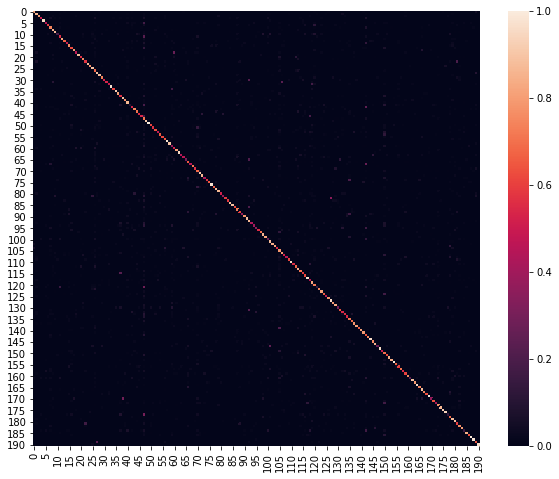

In [98]:
evaluate_confusion(rnn_generic, X_test, y_test)

Though a heatmap is perhaps not the most ideal way to visualize a confusion matrix of this dimension, the fact that it is so obviously nearly diagonal, with not too many common confusions indicates that this classifier is actually very good. Granted, it had to train for quite a while to get to this point, but we could easily repeat this process.

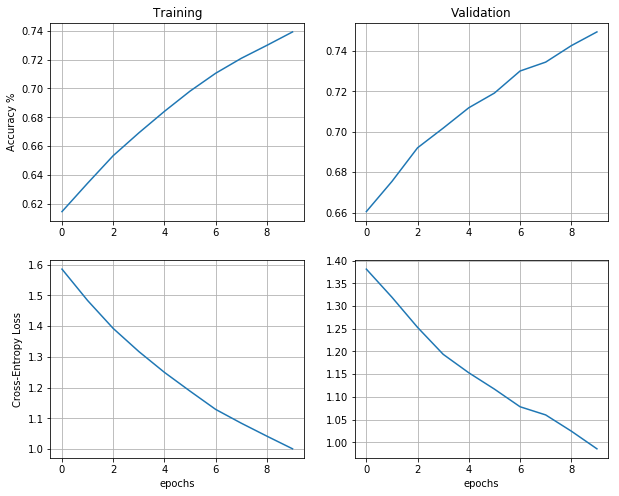

In [99]:
plot_history(history_generic)

Unfortunately, the history only captures the last few epochs, but we can see that the model was, in fact, still improving on both the training and validation sets.

Conclusion: RNNs are completely bonkers.

This next RNN will have the same general architecture as the previous one, but we'll adjust the size of the output layer.

In [55]:
rnn_lstm = Sequential()

rnn_lstm.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
rnn_lstm.add(LSTM(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_lstm.add(Dense(300, activation='relu'))
rnn_lstm.add(Dropout(0.2))
rnn_lstm.add(Dense(n_classes, activation='softmax'))

rnn_lstm.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
lstm_6 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_15 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_8 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 191)               57491     
Total params: 48,198,791
Trainable params: 438,591
Non-trainable params: 47,760,200
_________________________________________________________________


In [21]:
history_lstm = rnn_lstm.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 167s 3ms/step - loss: 4.6071 - acc: 0.1301 - val_loss: 4.1708 - val_acc: 0.2002
Epoch 2/10
58618/58618 [==============================] - 158s 3ms/step - loss: 4.0549 - acc: 0.2093 - val_loss: 3.7133 - val_acc: 0.2547
Epoch 3/10
58618/58618 [==============================] - 159s 3ms/step - loss: 3.6767 - acc: 0.2612 - val_loss: 3.4027 - val_acc: 0.2987
Epoch 4/10
58618/58618 [==============================] - 158s 3ms/step - loss: 3.4168 - acc: 0.2948 - val_loss: 3.1640 - val_acc: 0.3318
Epoch 5/10
58618/58618 [==============================] - 158s 3ms/step - loss: 3.2040 - acc: 0.3259 - val_loss: 3.0074 - val_acc: 0.3588
Epoch 6/10
58618/58618 [==============================] - 158s 3ms/step - loss: 2.9908 - acc: 0.3591 - val_loss: 2.7830 - val_acc: 0.3951
Epoch 7/10
58618/58618 [==============================] - 157s 3ms/step - loss: 2.7886 - acc: 0.3887 - val_loss: 2.5655 - 

/users/ckoehler/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall score of this model is 0.5597104278652126


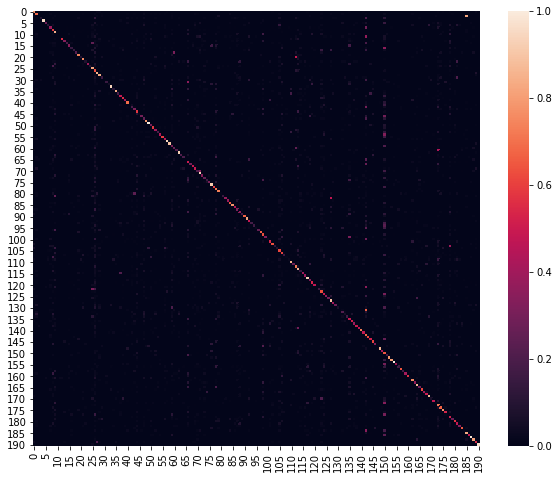

In [42]:
evaluate_confusion(rnn_lstm, X_test, y_test)

This model is currently performing worse, but we trained it for much less time than the previous LSTM. If we compare the accuracy scores on the tenth training epoch, we find that this one was at $55\%$, where the first model was at $52\%$. So, we might say that in preliminary testing, they're about equal.

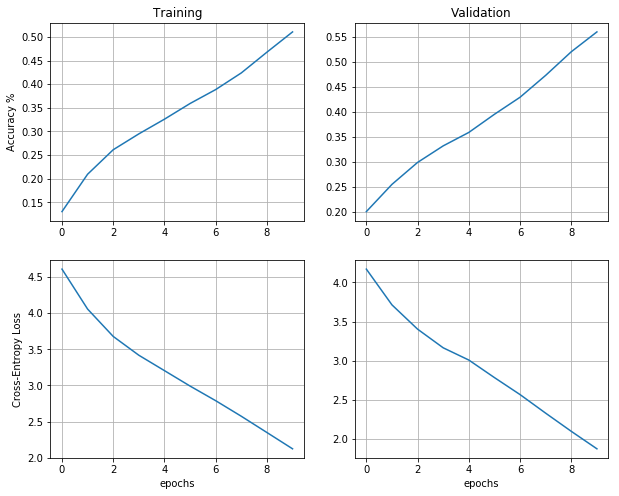

In [23]:
plot_history(history_lstm)

In [56]:
rnn_gru = Sequential()

rnn_gru.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
rnn_gru.add(GRU(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru.add(Dense(300, activation='relu'))
rnn_gru.add(Dropout(0.2))
rnn_gru.add(Dense(n_classes, activation='softmax'))

rnn_gru.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
gru_3 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dense_17 (Dense)             (None, 300)               60300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 191)               57491     
Total params: 48,118,591
Trainable params: 358,391
Non-trainable params: 47,760,200
_________________________________________________________________


In [25]:
history_gru = rnn_gru.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 107s 2ms/step - loss: 4.5078 - acc: 0.1551 - val_loss: 4.0941 - val_acc: 0.2092
Epoch 2/10
58618/58618 [==============================] - 106s 2ms/step - loss: 3.9919 - acc: 0.2210 - val_loss: 3.7632 - val_acc: 0.2513
Epoch 3/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.6388 - acc: 0.2602 - val_loss: 3.4182 - val_acc: 0.2902
Epoch 4/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.3942 - acc: 0.2920 - val_loss: 3.2031 - val_acc: 0.3297
Epoch 5/10
58618/58618 [==============================] - 106s 2ms/step - loss: 3.1838 - acc: 0.3288 - val_loss: 2.9688 - val_acc: 0.3711
Epoch 6/10
58618/58618 [==============================] - 105s 2ms/step - loss: 3.0191 - acc: 0.3572 - val_loss: 2.7930 - val_acc: 0.3964
Epoch 7/10
58618/58618 [==============================] - 106s 2ms/step - loss: 2.8010 - acc: 0.3923 - val_loss: 2.5900 - 

/users/ckoehler/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall score of this model is 0.5220925061605465


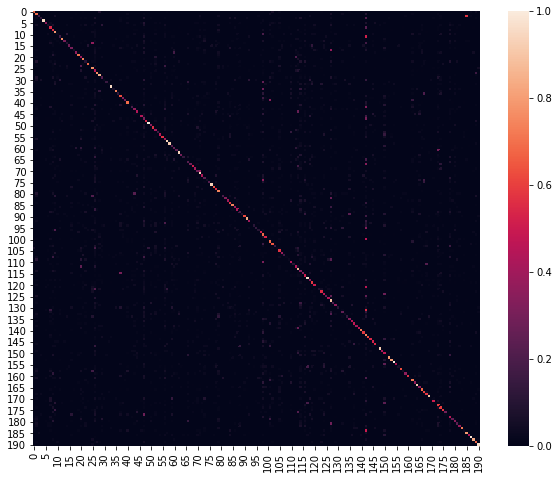

In [43]:
evaluate_confusion(rnn_gru, X_test, y_test)

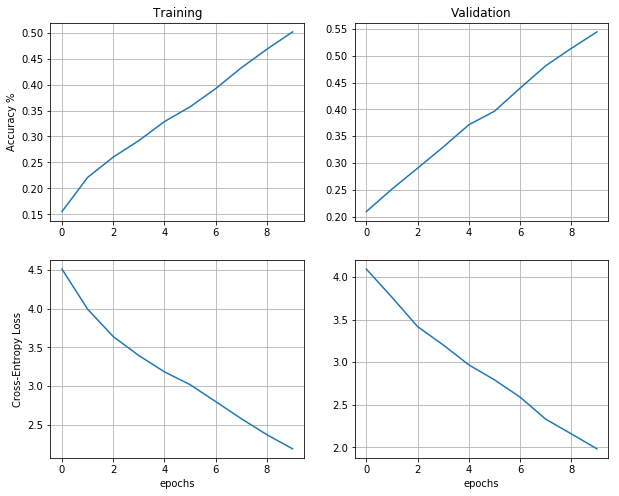

In [27]:
plot_history(history_gru)

Now, let's change some of the neuron counts and increase the dropout rate.

In [57]:
rnn_gru_tweak = Sequential()

rnn_gru_tweak.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
rnn_gru_tweak.add(GRU(300, dropout=0.3, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru_tweak.add(Dense(300, activation='relu'))
rnn_gru_tweak.add(Dropout(0.2))
rnn_gru_tweak.add(Dense(n_classes, activation='softmax'))

rnn_gru_tweak.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['acc'])
rnn_gru_tweak.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
gru_4 (GRU)                  (None, 300)               450900    
_________________________________________________________________
dense_19 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 191)               57491     
Total params: 48,358,891
Trainable params: 598,691
Non-trainable params: 47,760,200
_________________________________________________________________


In [29]:
history_gru_tweak = rnn_gru_tweak.fit(X_train, y_train, 
                                  validation_data=(X_test, y_test), 
                                  batch_size=1000, epochs=10)

Train on 58618 samples, validate on 19540 samples
Epoch 1/10
58618/58618 [==============================] - 155s 3ms/step - loss: 4.4758 - acc: 0.1595 - val_loss: 4.0262 - val_acc: 0.2149
Epoch 2/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.9423 - acc: 0.2268 - val_loss: 3.6033 - val_acc: 0.2624
Epoch 3/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.5600 - acc: 0.2730 - val_loss: 3.3515 - val_acc: 0.3017
Epoch 4/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.3125 - acc: 0.3099 - val_loss: 3.0780 - val_acc: 0.3526
Epoch 5/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.4115 - acc: 0.2973 - val_loss: 3.5063 - val_acc: 0.2884
Epoch 6/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.5137 - acc: 0.2749 - val_loss: 3.3641 - val_acc: 0.2982
Epoch 7/10
58618/58618 [==============================] - 154s 3ms/step - loss: 3.3205 - acc: 0.3008 - val_loss: 3.1402 - 

/users/ckoehler/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Recall score of this model is 0.4732952540056655


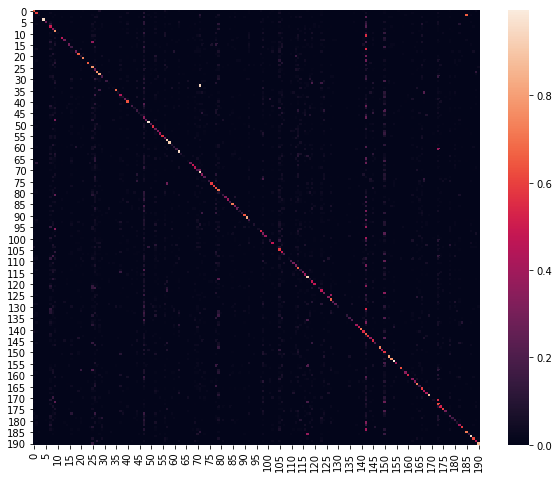

In [44]:
evaluate_confusion(rnn_gru_tweak, X_test, y_test)

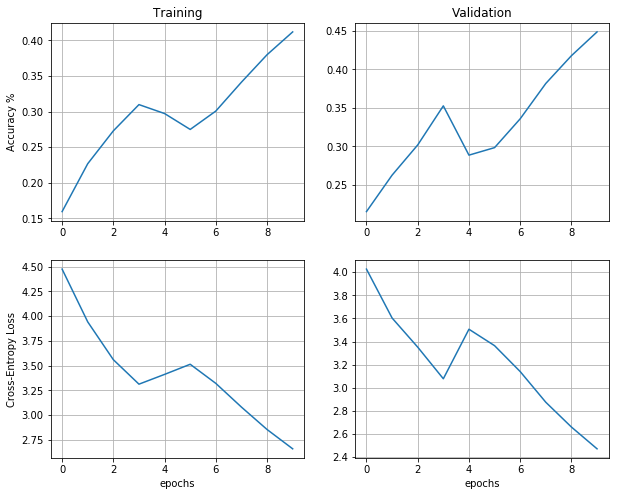

In [31]:
plot_history(history_gru_tweak)

## Determining the Best Model

We would now like to determine if one of our models is better than the rest and, if so, which one it is. We can do this by training each of our models in a cross-validation loop and finding performance on the CV set.

In [28]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=3, test_size=0.17, train_size=0.33)

In [30]:
y_int = np.argmax(y_train, axis=1)

In [70]:
def generate_model(name):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
    
    if name is 'gen':
        model.add(LSTM(200, dropout=0.2, 
                         recurrent_dropout=0.2,
                         return_sequences=False))
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))
        
    elif name is 'lstm':
        model.add(LSTM(200, dropout=0.2, 
                          recurrent_dropout=0.2,
                          return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))
        
    elif name is 'gru':
        model.add(GRU(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))

    elif name is 'grutweak':
        model.add(GRU(300, dropout=0.3, 
                         recurrent_dropout=0.2,
                         return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))

    else:
        raise ValueError('This model name is not valid.')
        
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

In [69]:
rnn_names = ['gen', 'lstm', 'gru', 'grutweak']

In [74]:
cv_scores = {}
history_data = {}
# 4 models * 3 splits/model * 3 minutes/epoch => not many epochs/split
n_epochs = 5

for name in rnn_names:
    model_scores = []
    model_history = []
    
    for train_idx, cv_idx in cv.split(X_train, y_train):
        train_data = X_train[train_idx]
        train_target = y_train[train_idx]
        cv_data = X_train[cv_idx]
        cv_target = y_train[cv_idx]
        
        model = generate_model(name)
        
        print('====================')
        print('Training Model: {}'.format(name))
        print('====================')
        
        history = model.fit(train_data, train_target, 
                            validation_data=(cv_data, cv_target),
                            epochs=n_epochs, batch_size=1000)
        
        rec = scorer(y_int[cv_idx], np.argmax(model.predict(cv_data), axis=1))
        model_scores.append(rec)
        model_history.append(history)
        
    cv_scores.update({name : model_scores})
    history_data.update({name : model_history})

Training Model: gen
Train on 19343 samples, validate on 9966 samples
Epoch 1/5
19343/19343 [==============================] - 62s 3ms/step - loss: 4.8979 - acc: 0.0894 - val_loss: 4.6575 - val_acc: 0.1107
Epoch 2/5
19343/19343 [==============================] - 60s 3ms/step - loss: 4.5677 - acc: 0.1304 - val_loss: 4.4227 - val_acc: 0.1699
Epoch 3/5
19343/19343 [==============================] - 60s 3ms/step - loss: 4.3564 - acc: 0.1723 - val_loss: 4.2408 - val_acc: 0.1966
Epoch 4/5
19343/19343 [==============================] - 60s 3ms/step - loss: 4.1714 - acc: 0.1931 - val_loss: 4.0834 - val_acc: 0.2092
Epoch 5/5
19343/19343 [==============================] - 60s 3ms/step - loss: 4.0152 - acc: 0.2124 - val_loss: 3.9303 - val_acc: 0.2320
Training Model: gen
Train on 19343 samples, validate on 9966 samples
Epoch 1/5
19343/19343 [==============================] - 62s 3ms/step - loss: 4.9084 - acc: 0.0873 - val_loss: 4.6792 - val_acc: 0.1109
Epoch 2/5
19343/19343 [=======================

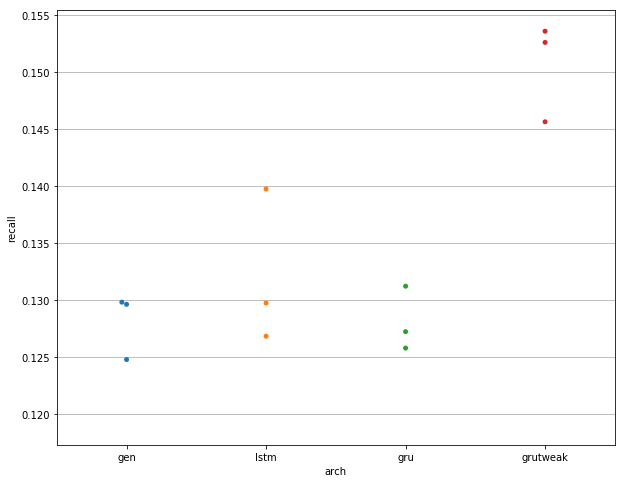

In [77]:
cv_df = pd.DataFrame(cv_scores)
cv_df['run'] = cv_df.index

cv_melted = cv_df.melt(id_vars='run', 
                       value_vars=['gen', 'lstm', 'gru', 'grutweak'],
                       value_name='recall', var_name='arch')

sns.swarmplot(data=cv_melted, x='arch', y='recall')
plt.show()

This gap is enough that we won't even bother with more subtle statistical methods, and we determine that the gru-tweak model is superior to the other models. We will use it as our go-to RNN model going forward.

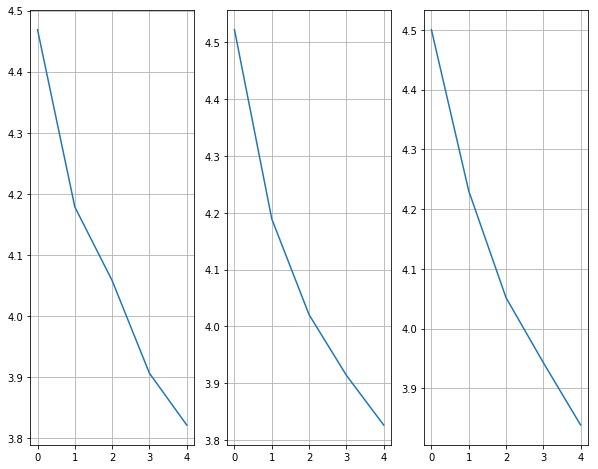

In [95]:
plt.figure()
i=1

for hist in history_data['grutweak']:
    
    n_epochs = len(hist.history['val_loss'])
    plt.subplot(1, 3, i)
    plt.plot(np.arange(0, n_epochs), hist.history['val_loss'])
    i += 1
plt.show()

## Monotonically Better

"RNNs are neural networks and everything works monotonically better (if done right) if you put on your deep learning hat and start stacking models up like pancakes."

-Andrej Karpathy, "The Unreasonable Effectiveness of Recurrent Neural Networks"

Now, we'll take our most successful architecture and add another layer on top of it. We will also decrease the number of parameters so that it runs in a reasonable amount of time.

In [38]:
def generate_model(name):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_size,
                        input_length=max_length,
                        weights=[embedding_matrix],
                        trainable=False))
    
    if name is 'gen':
        model.add(LSTM(200, dropout=0.2, 
                         recurrent_dropout=0.2,
                         return_sequences=False))
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))
        
    elif name is 'lstm':
        model.add(LSTM(200, dropout=0.2, 
                          recurrent_dropout=0.2,
                          return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))
        
    elif name is 'gru':
        model.add(GRU(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))

    elif name is 'grutweak':
        model.add(GRU(300, dropout=0.3, 
                         recurrent_dropout=0.2,
                         return_sequences=False))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))
        
    elif name is 'deep':
        model.add(GRU(100, dropout=0.3, 
                         recurrent_dropout=0.2,
                         return_sequences=True))
        model.add(GRU(100, dropout=0.3, 
                         recurrent_dropout=0.2,
                         return_sequences=False))
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(n_classes, activation='softmax'))

    else:
        raise ValueError('This model name is not valid.')
        
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

In [41]:
rnn_deep = generate_model('deep')

rnn_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 200)         47760200  
_________________________________________________________________
gru_12 (GRU)                 (None, 1000, 100)         90300     
_________________________________________________________________
gru_13 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 191)               38391     
Total params: 47,969,391
Trainable params: 209,191
Non-trainable params: 47,760,200
__________________________________________________________

In [42]:
X_train, X_test, y_train, y_test = train_test_split(sequences, authors, 
                                                    train_size=0.1, test_size=0.02)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
y_int_train = np.argmax(y_train, axis=1)
y_int_test = np.argmax(y_test, axis=1)

As it turns out, multi-layer RNNs are a real challenge to train, especially on the old version of tensorflow that M2 is using, so in addition to simplifying the model slightly, I've also subsampled pretty heavily, and I will only be running three cross-validation folds. 

In [43]:
n_epochs = 10
train_all = {}
test_all = {}

cv = ShuffleSplit(n_splits=3)

i=0
for train_idx, cv_idx in cv.split(X_train, y_train):
    train_data = X_train[train_idx]
    train_target = y_train[train_idx]
    cv_data = X_train[cv_idx]
    cv_target = y_train[cv_idx]
    
    rnn_deep = generate_model('deep')

    train_recall = []
    test_recall = []
    
    for _ in range(n_epochs):
    
        history_deep = rnn_deep.fit(train_data, train_target,
                                      validation_data=(X_test, y_test),
                                      epochs=1, batch_size=1000,
                                      verbose=1)
        rec_train = scorer(y_int_train[train_idx], 
                           np.argmax(rnn_deep.predict(train_data), axis=1))
        rec_test = scorer(y_int_train[cv_idx], 
                           np.argmax(rnn_deep.predict(cv_data), axis=1))
        train_recall.append(rec_train)
        test_recall.append(rec_test)
    train_all.update({i : train_recall})
    test_all.update({i : test_recall})
    i += 1

Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [==============================] - 27s 4ms/step - loss: 5.0938 - acc: 0.0626 - val_loss: 4.9893 - val_acc: 0.0806
Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [==============================] - 26s 4ms/step - loss: 4.9200 - acc: 0.0796 - val_loss: 4.8899 - val_acc: 0.0895
Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [==============================] - 25s 4ms/step - loss: 4.8518 - acc: 0.0879 - val_loss: 4.8487 - val_acc: 0.0921
Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [==============================] - 26s 4ms/step - loss: 4.8048 - acc: 0.0987 - val_loss: 4.7912 - val_acc: 0.1023
Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [==============================] - 26s 4ms/step - loss: 4.7519 - acc: 0.1027 - val_loss: 4.7616 - val_acc: 0.0997
Train on 7033 samples, validate on 1564 samples
Epoch 1/1
7033/7033 [=====================

Behind the scenes: These times are very misleading if used to estimate how much time this all took. Because of some issue involving GPU memory transfer, the predict function in Keras actually takes a crazy amount of time to run, multiple times longer than it takes to train the given model on the same data, and there are no known fixes. So the times above only add up to about 15 minutes, but the cell something like 2.5 hours to run in total.

In [48]:
train_df = pd.DataFrame(train_all)
train_means = train_df.mean(axis=1)
train_stds = train_df.std(axis=1)

In [49]:
test_df = pd.DataFrame(test_all)
test_means = test_df.mean(axis=1)
test_stds = test_df.std(axis=1)

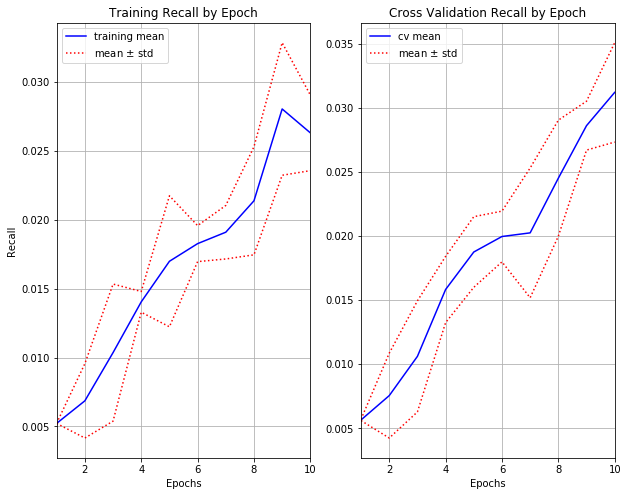

In [54]:
plt.figure()

plt.subplot(121)
plt.plot(np.arange(1, n_epochs + 1), train_means, 'b', label='training mean')
plt.plot(np.arange(1, n_epochs + 1), train_means + train_stds, 'r:', label='mean $\pm$ std')
plt.plot(np.arange(1, n_epochs + 1), train_means - train_stds, 'r:')
plt.xlim((1,10))
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training Recall by Epoch')

plt.subplot(122)
plt.plot(np.arange(1, n_epochs + 1), test_means, 'b', label='cv mean')
plt.plot(np.arange(1, n_epochs + 1), test_means + test_stds, 'r:', label='mean $\pm$ std')
plt.plot(np.arange(1, n_epochs + 1), test_means - test_stds, 'r:')
plt.xlim((1,10))
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.title('Cross Validation Recall by Epoch')

plt.show()

Obviously, these estimates aren't great. We've only run three cross-validation folds, so the sample means are unstable, and we've only taken the sample standard deviations instead of estimating the actual standard deviations. We also had to subsample heavily and reduce the complexity of the model to even get the model to train without crashing arbitrarily high-end compute nodes. There was also no way this could be run to convergence, but it is nice to see how an RNN with multiple GRU layers performs on the first few iterations.

In [55]:
rnn_deep = generate_model('deep')

history_deep = rnn_deep.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=n_epochs, batch_size=1000,
                            verbose=1)

Train on 7815 samples, validate on 1564 samples
Epoch 1/10
7815/7815 [==============================] - 28s 4ms/step - loss: 5.0922 - acc: 0.0615 - val_loss: 4.9267 - val_acc: 0.0812
Epoch 2/10
7815/7815 [==============================] - 27s 3ms/step - loss: 4.9058 - acc: 0.0857 - val_loss: 4.8394 - val_acc: 0.0959
Epoch 3/10
7815/7815 [==============================] - 27s 3ms/step - loss: 4.8138 - acc: 0.0967 - val_loss: 4.7740 - val_acc: 0.1004
Epoch 4/10
7815/7815 [==============================] - 27s 3ms/step - loss: 4.7356 - acc: 0.1052 - val_loss: 4.7004 - val_acc: 0.1042
Epoch 5/10
7815/7815 [==============================] - 27s 4ms/step - loss: 4.6724 - acc: 0.1126 - val_loss: 4.6398 - val_acc: 0.1132
Epoch 6/10
7815/7815 [==============================] - 26s 3ms/step - loss: 4.6031 - acc: 0.1200 - val_loss: 4.6147 - val_acc: 0.1189
Epoch 7/10
7815/7815 [==============================] - 28s 4ms/step - loss: 4.5504 - acc: 0.1298 - val_loss: 4.5241 - val_acc: 0.1279
Epoch 8

In [56]:
test_recall = scorer(y_int_test, 
                     np.argmax(rnn_deep.predict(X_test), axis=1))

In [63]:
print('Estimated test set performance with one standard deviation '
      'interval: {}'.format([test_recall - test_stds.values[-1],
                             test_recall + test_stds.values[-1]]))

Estimated test set performance with one standard deviation interval: [0.055541022300653574, 0.063289724898428559]


## Exceptional Work (Deliberately Omitted)

Now, under normal circumstances, this is where the "exceptional work" portion would go, but it's finals week, and I have other things to worry about. I'm pretty sure my grade is fine, and knowing myself, any of the recommended paths are projects I would accidentally end up spending whole days on (god knows I've already done that earlier this semester), so I'm choosing to call it here.